In [1]:
import math, sys, functools, os, codecs
from glob import glob
import sqlite3
import numpy as np
import numpy.random as rd
from numpy import matrix
import pandas as pd
import scipy as sp
from scipy import stats as st
from datetime import  datetime as dt
from collections import Counter
from itertools import chain
import multiprocessing as mp

import matplotlib
from matplotlib import font_manager
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
sns.set(style="whitegrid", palette="muted", color_codes=True)
plt.rcParams["patch.force_edgecolor"] = True
%matplotlib inline

%config InlineBackend.figure_format='retina'

# OS判別 ======================
flag_win32 = False
try:
    os.uname()
except AttributeError:
    flag_win32 = True

# Mac用フォント設定
if not flag_win32:
    font_path = '/Library/Fonts/Osaka.ttf'
    font_prop = font_manager.FontProperties(fname=font_path)
    matplotlib.rcParams['font.family'] = font_prop.get_name()
    plt.rcParams['font.family'] = 'Osaka'
    
import IPython.display as ipyd
from matplotlib import animation as ani

分散既知とする

$
x_i \sim N(0, 1)
$

n個サンプル集めて、その標本平均が$\bar{x}$であった。  
有意水準$(\alpha)=0.05$、検出力$(1-\beta)=0.8$として、様々な効果量でどのようになるかをみてみる。

(-0.1, 0.5)

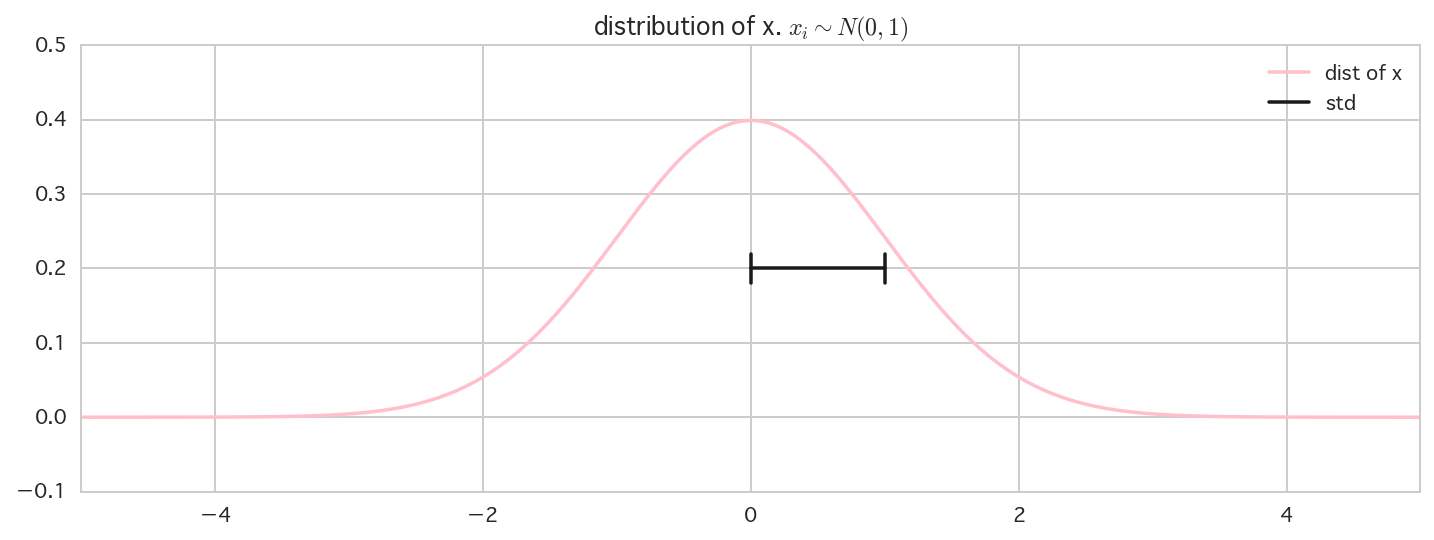

In [41]:
# 平均値
mean = 0
sd   = 1

xx = np.linspace(-5, 5, 301)
pdf = st.norm.pdf(xx, loc=mean, scale=sd)

plt.figure(figsize=(12,4))
plt.plot(xx, pdf, "pink", label="dist of x")

# 標準偏差バーの描画
plt.plot([0, sd],[0.2, 0.2], "k")
plt.plot([sd, sd],[0.18, 0.22], "k", label="std")
plt.plot([0, 0],[0.18, 0.22], "k")

plt.title("distribution of x. $x_i \sim N(0, 1)$")
plt.legend(loc="best")
plt.xlim(-5, 5)
plt.ylim(-0.1, 0.5)

(-0.1, 1.5)

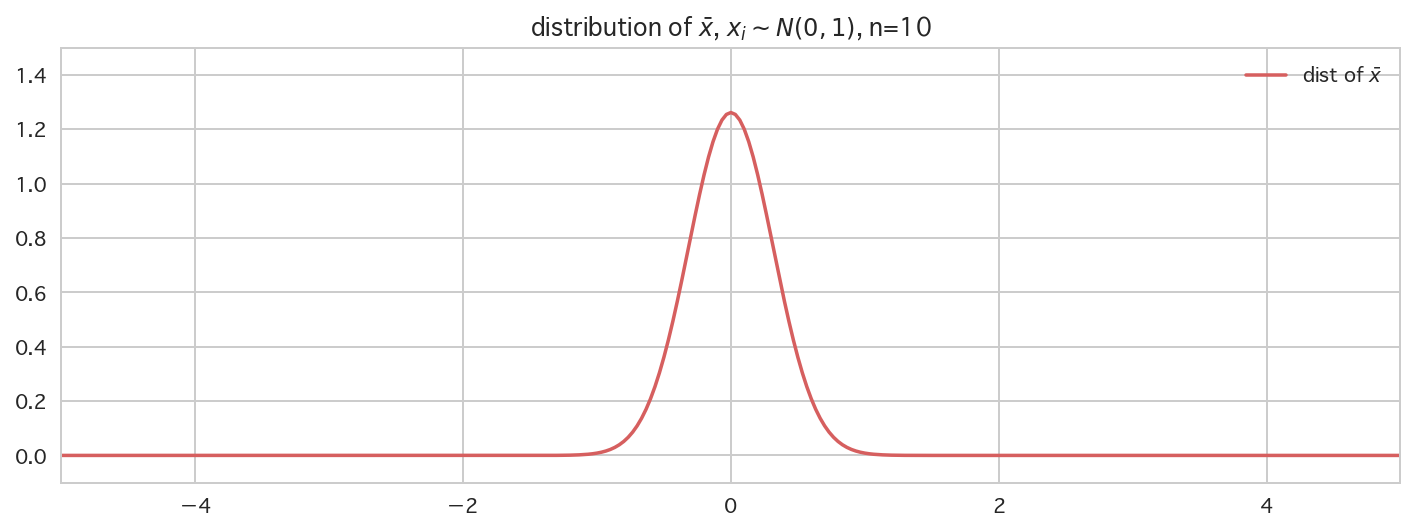

In [2]:
# 平均値
mean = 0
sd   = 1
n = 10

# 標準誤差
se = sd/np.sqrt(n)  

xx = np.linspace(-5, 5, 301)
pdf = st.norm.pdf(xx, loc=mean, scale=se)


plt.figure(figsize=(12,4))
plt.plot(xx, pdf, "r", label="dist of $\\bar{x}$")

# 標準偏差バーの描画
# plt.plot([0, sd],[0.2, 0.2], "k")
# plt.plot([sd, sd],[0.18, 0.22], "k", label="std")
# plt.plot([0, 0],[0.18, 0.22], "k")

plt.title("distribution of $\\bar{x}$, $x_i \sim N(0, 1)$" + ", n={}".format(n))
plt.legend(loc="best")
plt.xlim(-5, 5)
plt.ylim(-0.1, 1.5)

(-0.1, 1.5)

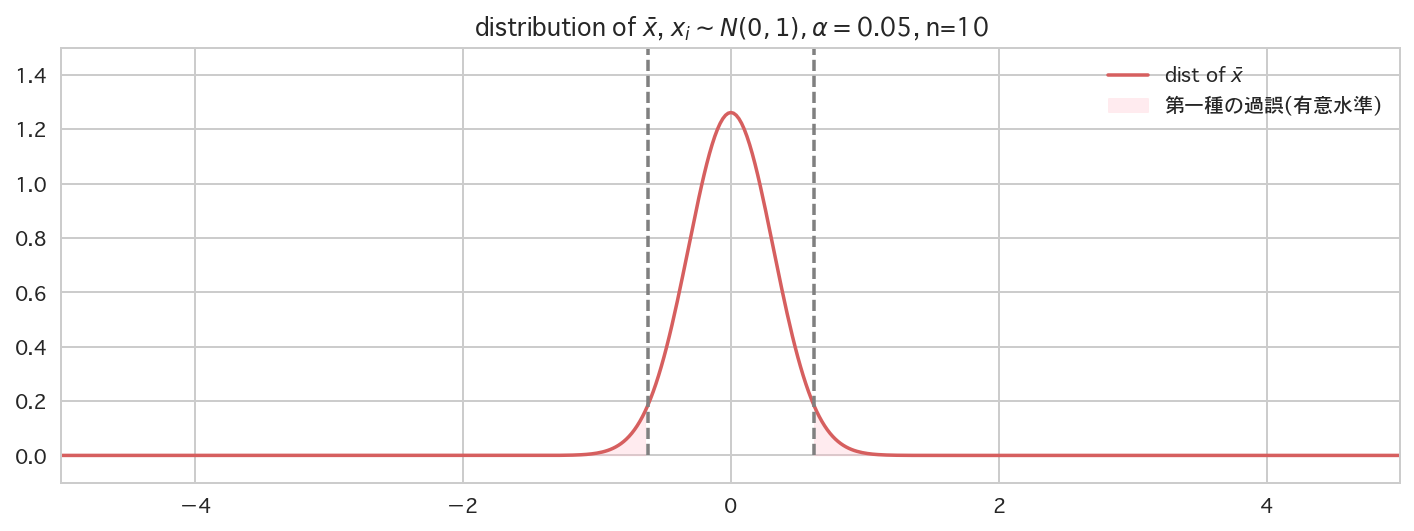

In [4]:
# 平均値
mean = 0
sd   = 1
n = 10
alpha = 0.05

# 標準誤差
se = sd/np.sqrt(n)  

# (両側検定)有意水準の右側の値
border_high = st.norm.isf(alpha/2, loc=mean, scale=se)
border_high_idx = np.argmin(np.abs(xx-border_high))

# (両側検定)有意水準の左側の値
border_low = st.norm.isf(1-alpha/2, loc=mean, scale=se)
border_low_idx = np.argmin(np.abs(xx-border_low))


xx = np.linspace(-5, 5, 501)
pdf = st.norm.pdf(xx, loc=mean, scale=se)

plt.figure(figsize=(12,4))
plt.plot(xx, pdf, "r", label="dist of $\\bar{x}$")

plt.plot([border_low, border_low], [0, 1.5], "--", color="gray")
plt.plot([border_high, border_high], [0, 1.5], "--", color="gray")
    
plt.fill_between(xx[border_high_idx:], pdf[border_high_idx:],alpha=0.3, color="pink", 
                 label="第一種の過誤(有意水準)")
plt.fill_between(xx[:border_low_idx], pdf[:border_low_idx],alpha=0.3, color="pink")

# 標準偏差バーの描画
# plt.plot([0, sd],[0.2, 0.2], "k")
# plt.plot([sd, sd],[0.18, 0.22], "k", label="std")
# plt.plot([0, 0],[0.18, 0.22], "k")

plt.title("distribution of $\\bar{x}$, $x_i \sim N(0, 1), \\alpha=$" + "{}, n={}".format(alpha, n))
plt.legend(loc="best")
plt.xlim(-5, 5)
plt.ylim(-0.1, 1.5)

In [5]:
def show_graph(null_hypo_mean, sample_mean, n, sd, alpha, x_min, x_max, y_min, y_max, 
               fig=None, true_hypo="NULL",fill_inner=False, show_null=True, show_alt=True):
    """
    有意水準(α), サンプルサイズ(n), 効果量(Δ)を与えて、検定力(β)を計算するケース
    """
    assert true_hypo in ["NULL", "ALT"]
    
    # x軸のデータ
    xx = np.linspace(x_min, x_max, 801)
    
    # 効果量
    effect_size = (sample_mean-null_hypo_mean)/sd
    #m2 = mean + effect_size*sd
    
    # 標準誤差
    se = sd/np.sqrt(n)  
    
    # (両側検定)有意水準の右側の値
    border_high = st.norm.isf(alpha/2, loc=null_hypo_mean, scale=se)
    border_high_idx = np.argmin(np.abs(xx-border_high))
    
    # (両側検定)有意水準の左側の値
    border_low = st.norm.isf(1-alpha/2, loc=null_hypo_mean, scale=se)
    border_low_idx = np.argmin(np.abs(xx-border_low))

    # 正規分布の密度関数
    pdf_null   = st.norm.pdf(xx, loc=null_hypo_mean, scale=se)
    pdf_sample = st.norm.pdf(xx, loc=sample_mean, scale=se)
    
    power_upper = 1-st.norm.cdf(xx[border_high_idx], loc=sample_mean, scale=se)
    power_lower = st.norm.cdf(xx[border_low_idx], loc=sample_mean, scale=se)

    # グラフの描画
    if fig is None:
        plt.figure(figsize=(12,4))
    
    if true_hypo == "NULL":
        col_null = "r"
        col_alt  = "g"
    else:
        col_null = "b"
        col_alt  = "r"
        
    
    plt.scatter([null_hypo_mean, null_hypo_mean], [0, 0], s=50, c=col_null, zorder=100)
    plt.scatter([sample_mean, sample_mean], [0, 0], s=50, c=col_alt, zorder=100)
    
    if show_null:
        plt.plot(xx, pdf_null, color=col_null, label="Mean distribution of null hypothesis.")

    if show_alt:
        plt.plot(xx, pdf_sample, color=col_alt, label="Mean distribution of sample data.")
    
    if fill_inner:
        if show_alt:
            plt.fill_between(xx[border_low_idx:border_high_idx], pdf_sample[border_low_idx:border_high_idx],
                             alpha=0.3, color=col_alt, label="第二種の過誤")
        if show_null:
            plt.fill_between(xx[border_low_idx:border_high_idx], pdf_null[border_low_idx:border_high_idx],
                             alpha=0.3, color=col_null, label="第一種の過誤")
    else:
        if show_alt:
            plt.fill_between(xx[border_high_idx:], pdf_sample[border_high_idx:],alpha=0.3, color=col_alt, 
                             label="検出力(1-β)")
            plt.fill_between(xx[:border_low_idx], pdf_sample[:border_low_idx],alpha=0.3, color=col_alt)
        
        if show_null:
            plt.fill_between(xx[border_high_idx:], pdf_null[border_high_idx:],alpha=0.3, color=col_null, 
                             label="第一種の過誤(有意水準)")
            plt.fill_between(xx[:border_low_idx], pdf_null[:border_low_idx],alpha=0.3, color=col_null)
    
    plt.text(null_hypo_mean-0.2, np.max(pdf_null)*1.05, "帰無仮説")   
    plt.text(sample_mean-0.2, np.max(pdf_sample)*1.05, "対立仮説")
    
    
    plt.plot([border_low, border_low], [0, y_max], "--", color="gray")
    plt.plot([border_high, border_high], [0, y_max], "--", color="gray")
    
    # 標準偏差バーの描画
#     plt.plot([null_hypo_mean, null_hypo_mean+sd],[y_max/3,y_max/3], "k")
#     plt.plot([null_hypo_mean+sd, null_hypo_mean+sd],[y_max/3-y_max/50,y_max/3+y_max/50], "k", label="std")
#     plt.plot([null_hypo_mean, null_hypo_mean],[y_max/3-y_max/50,y_max/3+y_max/50], "k")
    
    plt.title("平均値の分布 n={1}, null_mean={2}, sample_mean={3:0.3f}, 効果量={4:0.3f}, 検出力(1-β)={5:0.3f}".format(
           true_hypo, n, null_hypo_mean, sample_mean, effect_size, power_upper+power_lower))
    plt.legend(loc="best")
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    return power_upper+power_lower

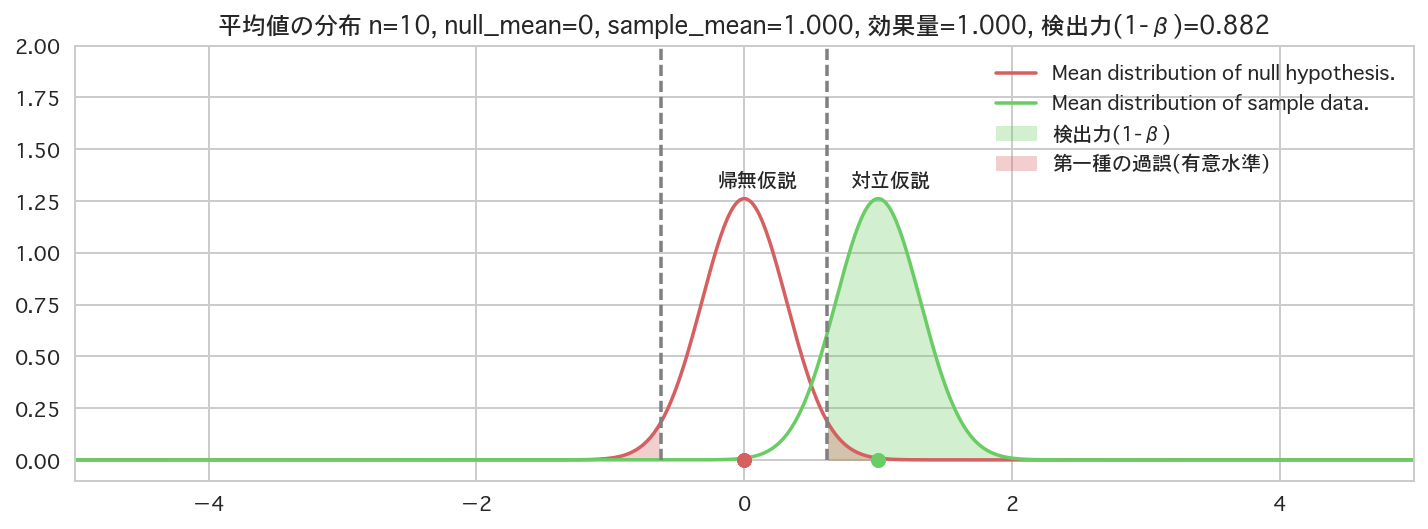

In [6]:
_ = show_graph(null_hypo_mean=0, sample_mean=1, n=10, sd=1, alpha=0.05, 
               x_min=-5, x_max=5, y_min=-0.1, y_max=2, true_hypo="NULL")

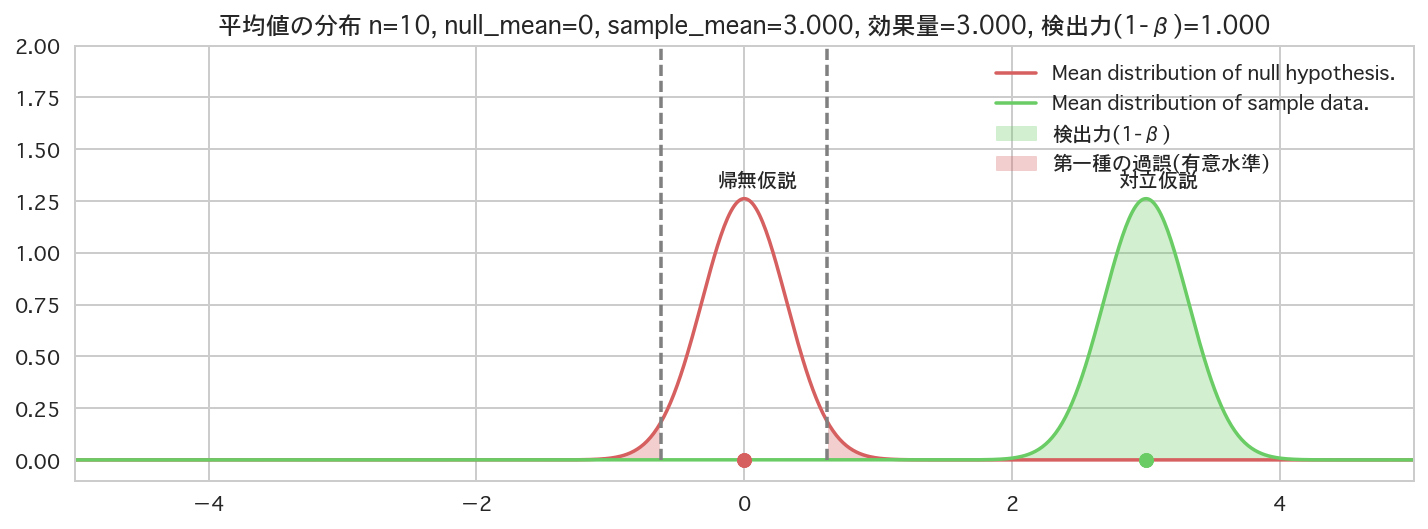

In [7]:
_ = show_graph(null_hypo_mean=0, sample_mean=3, n=10, sd=1, alpha=0.05, 
               x_min=-5, x_max=5, y_min=-0.1, y_max=2, true_hypo="NULL")

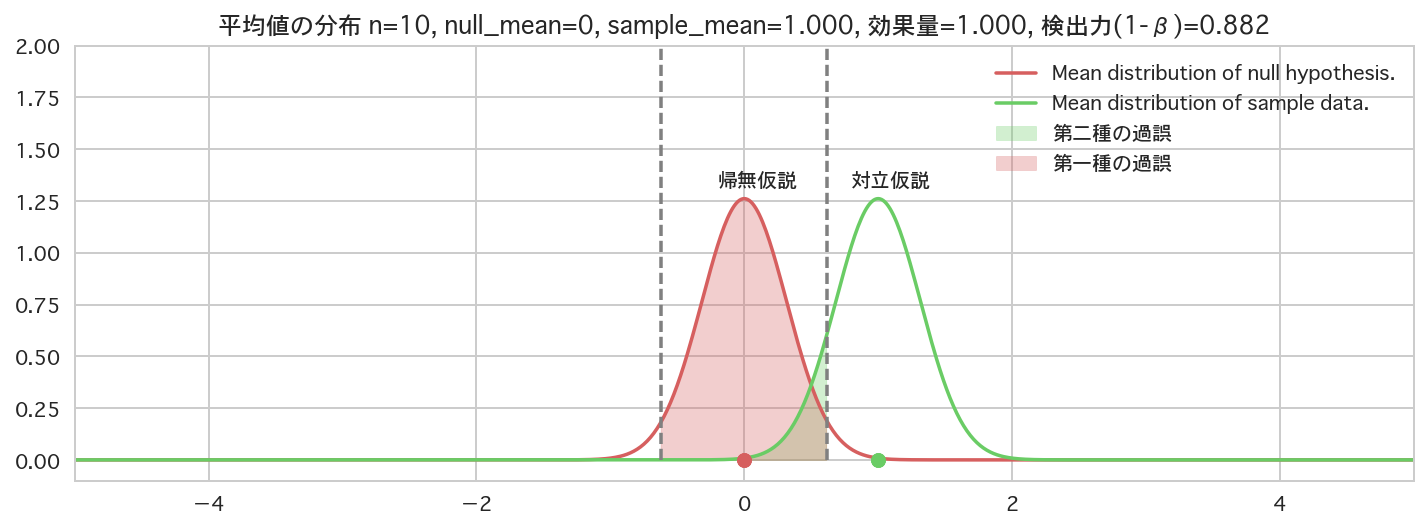

In [8]:
_ = show_graph(null_hypo_mean=0, sample_mean=1, n=10, sd=1, alpha=0.05, 
               x_min=-5, x_max=5, y_min=-0.1, y_max=2, true_hypo="NULL", fill_inner=True)

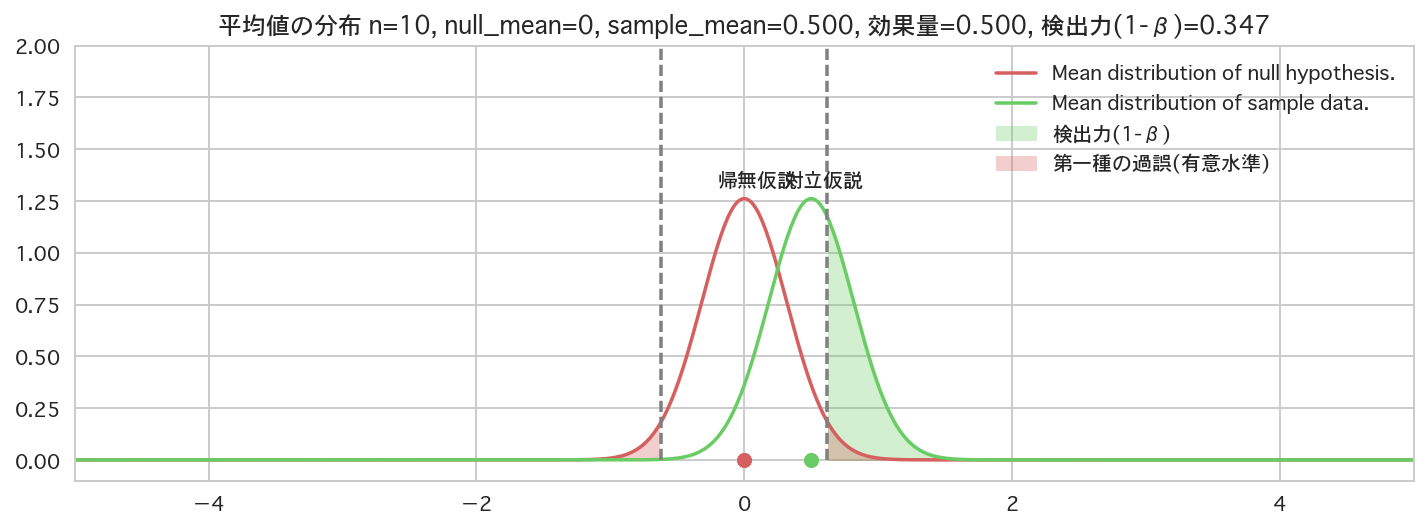

In [9]:
_ = show_graph(null_hypo_mean=0, sample_mean=0.5, n=10, sd=1, alpha=0.05, x_min=-5, x_max=5, y_min=-0.1, y_max=2)

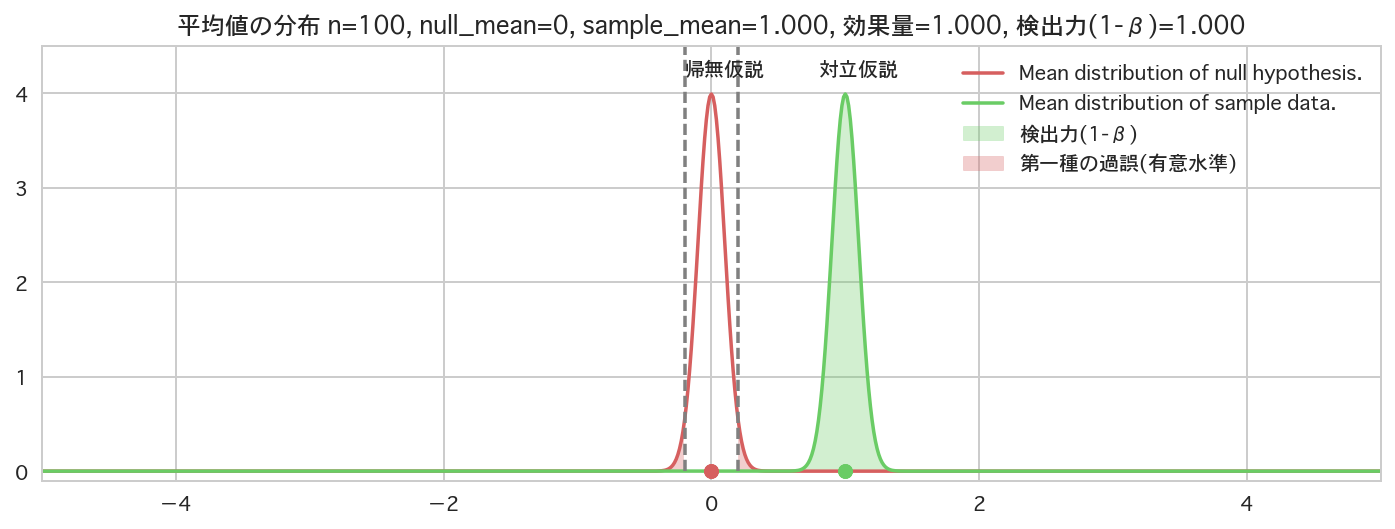

In [10]:
_ = show_graph(null_hypo_mean=0, sample_mean=1, n=100, sd=1, alpha=0.05, x_min=-5, x_max=5, y_min=-0.1, y_max=4.5)

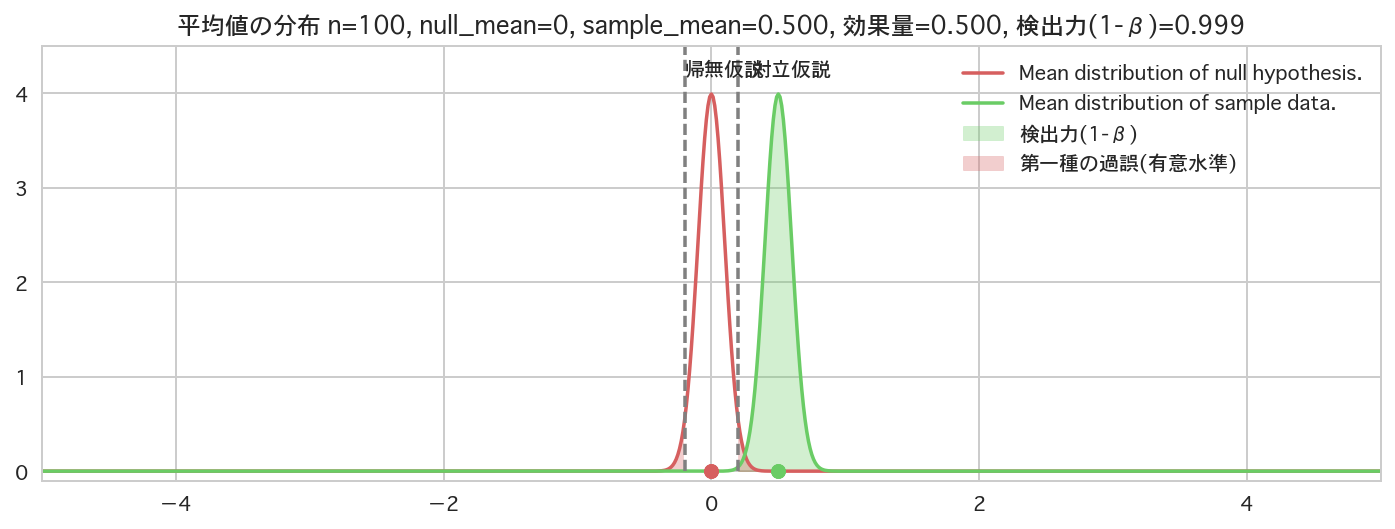

In [11]:
_ = show_graph(null_hypo_mean=0, sample_mean=0.5, n=100, sd=1, alpha=0.05, x_min=-5, x_max=5, y_min=-0.1, y_max=4.5)

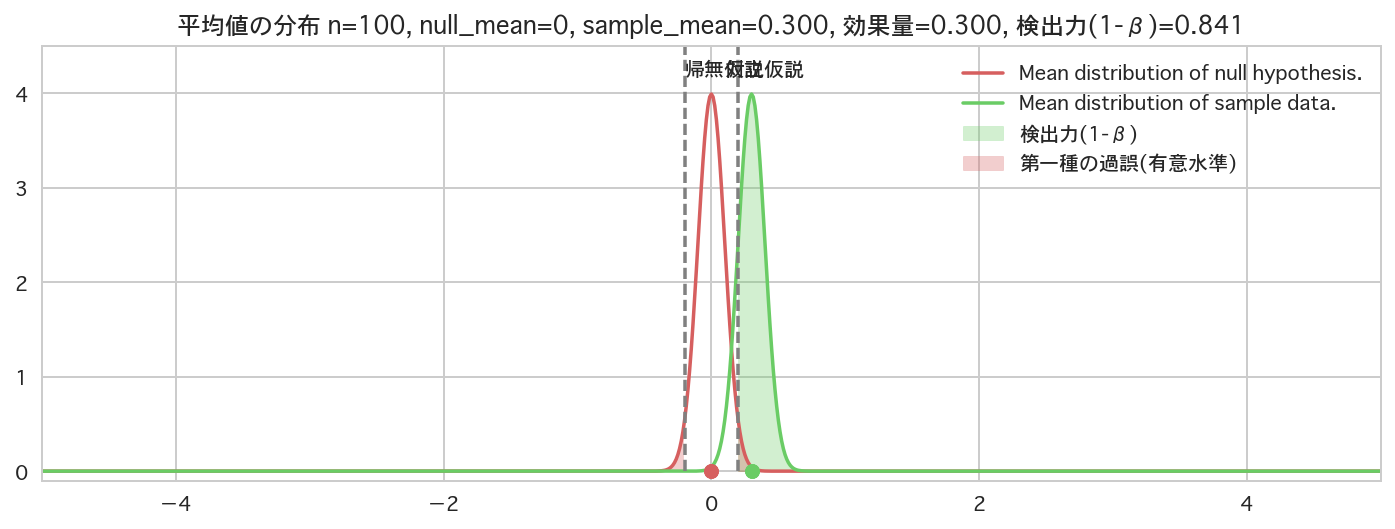

In [12]:
_ = show_graph(null_hypo_mean=0, sample_mean=0.3, n=100, sd=1, alpha=0.05, x_min=-5, x_max=5, y_min=-0.1, y_max=4.5)

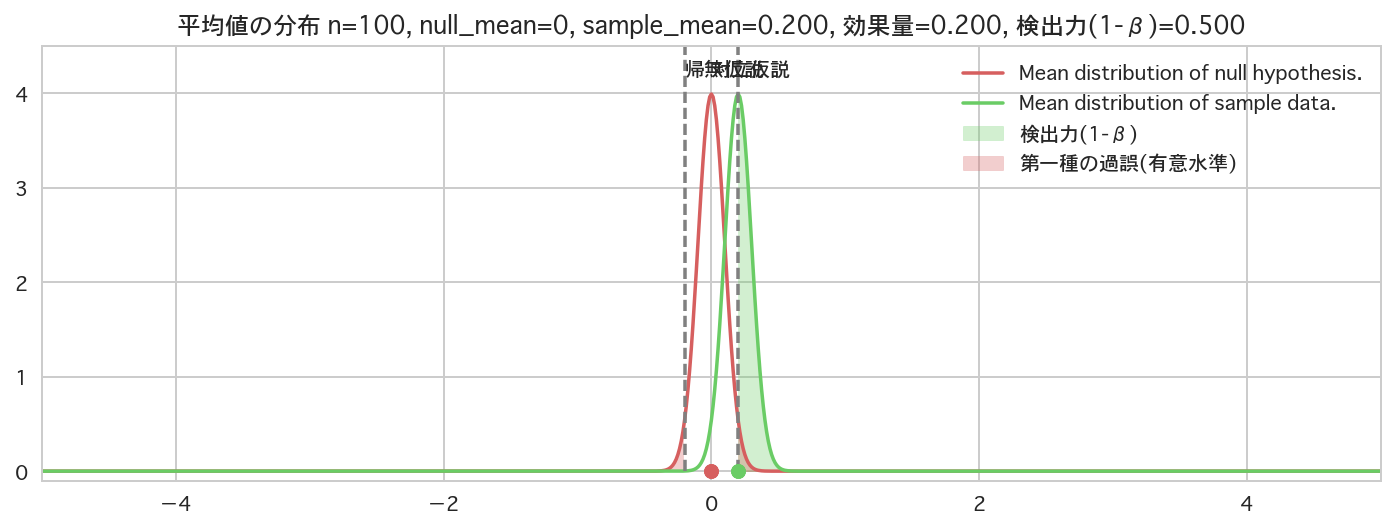

In [13]:
_ = show_graph(null_hypo_mean=0, sample_mean=0.2, n=100, sd=1, alpha=0.05, x_min=-5, x_max=5, y_min=-0.1, y_max=4.5)

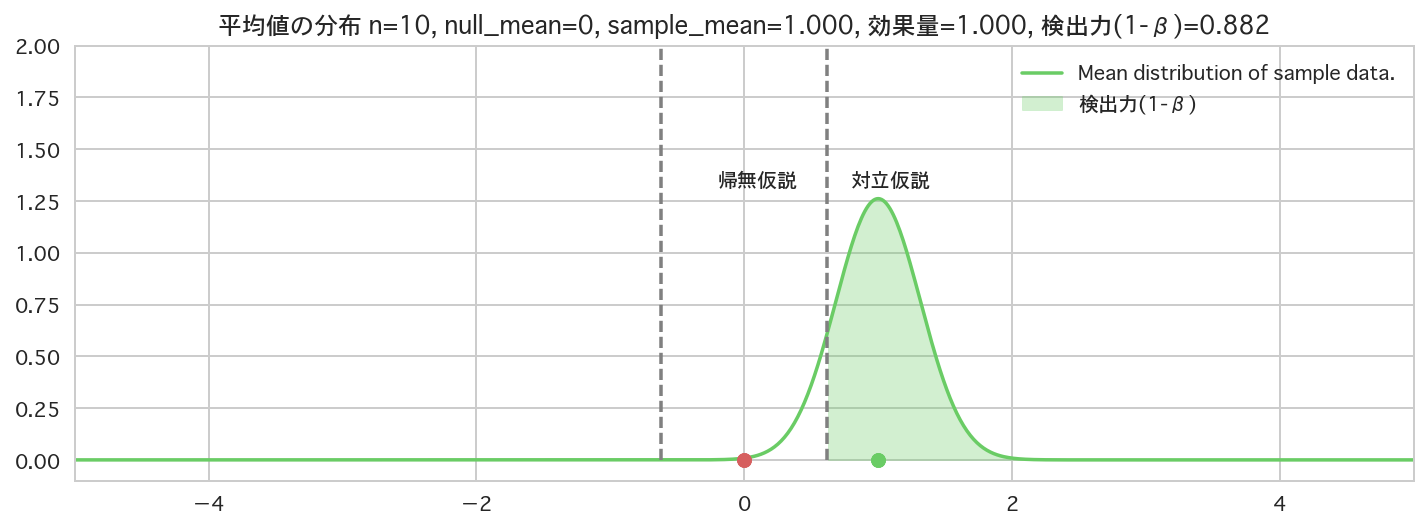

In [14]:
_ = show_graph(null_hypo_mean=0, sample_mean=1, n=10, sd=1, alpha=0.05, 
               x_min=-5, x_max=5, y_min=-0.1, y_max=2, true_hypo="NULL",
               show_null=False, show_alt=True)

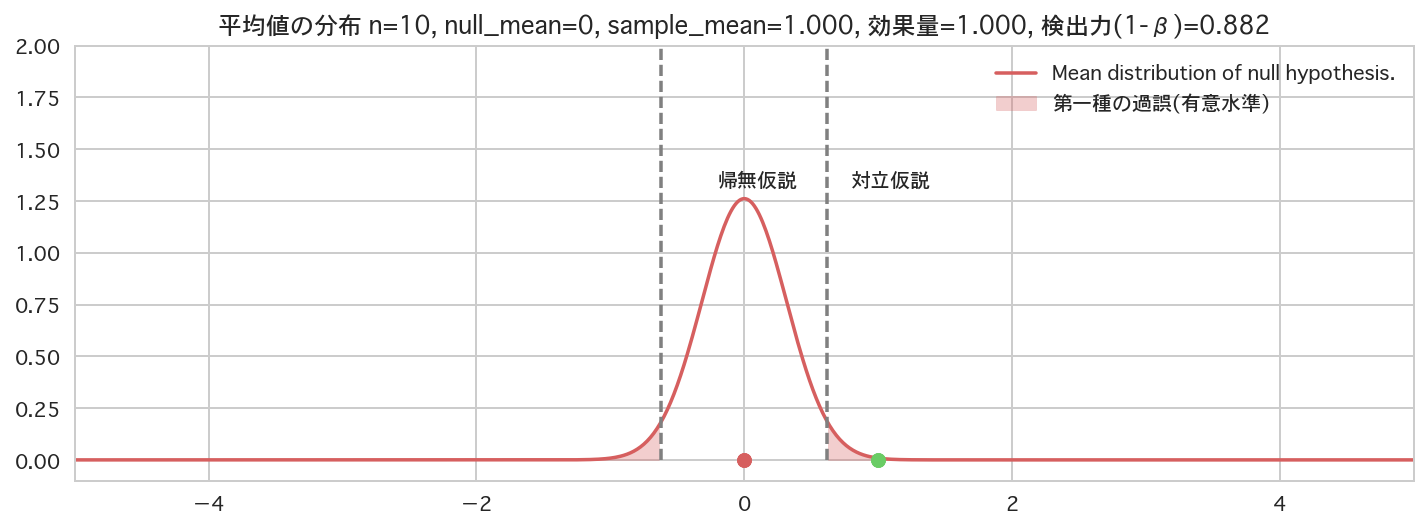

In [15]:
_ = show_graph(null_hypo_mean=0, sample_mean=1, n=10, sd=1, alpha=0.05, 
               x_min=-5, x_max=5, y_min=-0.1, y_max=2, true_hypo="NULL",
               show_null=True, show_alt=False)

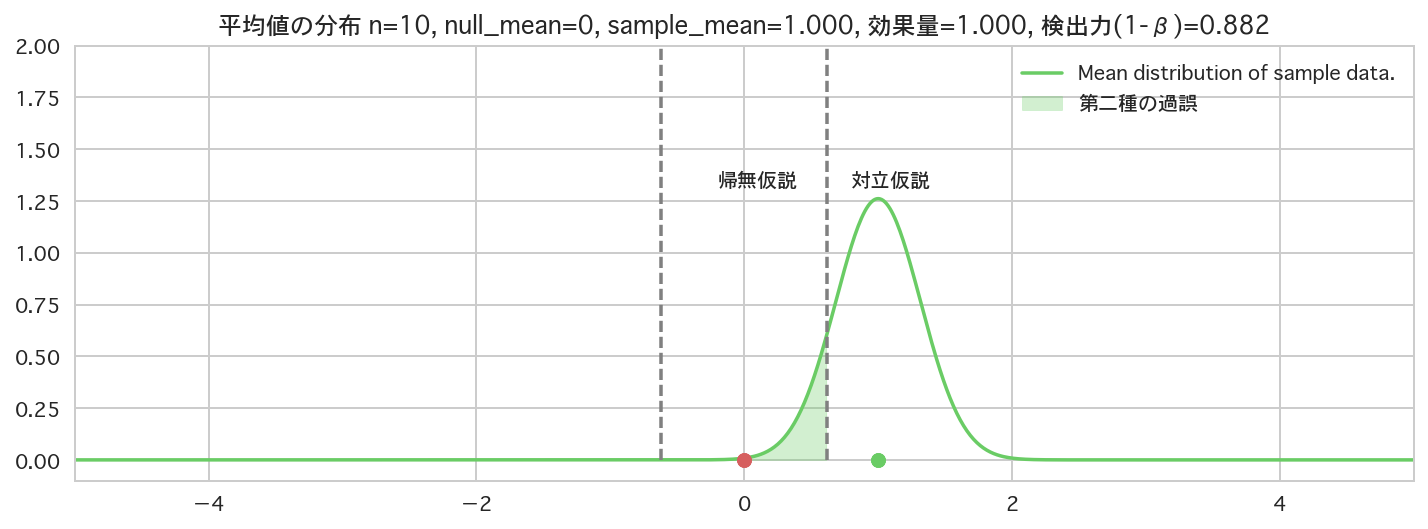

In [16]:
_ = show_graph(null_hypo_mean=0, sample_mean=1, n=10, sd=1, alpha=0.05, 
               x_min=-5, x_max=5, y_min=-0.1, y_max=2, true_hypo="NULL",
               show_null=False, show_alt=True, fill_inner=True)

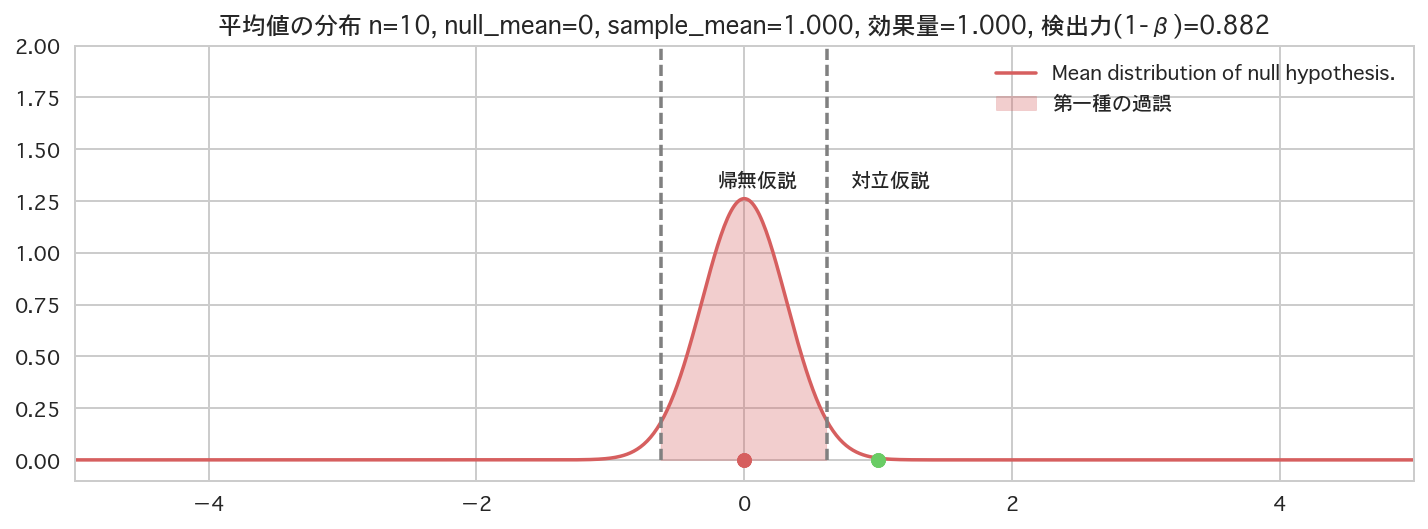

In [17]:
_ = show_graph(null_hypo_mean=0, sample_mean=1, n=10, sd=1, alpha=0.05, 
               x_min=-5, x_max=5, y_min=-0.1, y_max=2, true_hypo="NULL",
               show_null=True, show_alt=False, fill_inner=True)

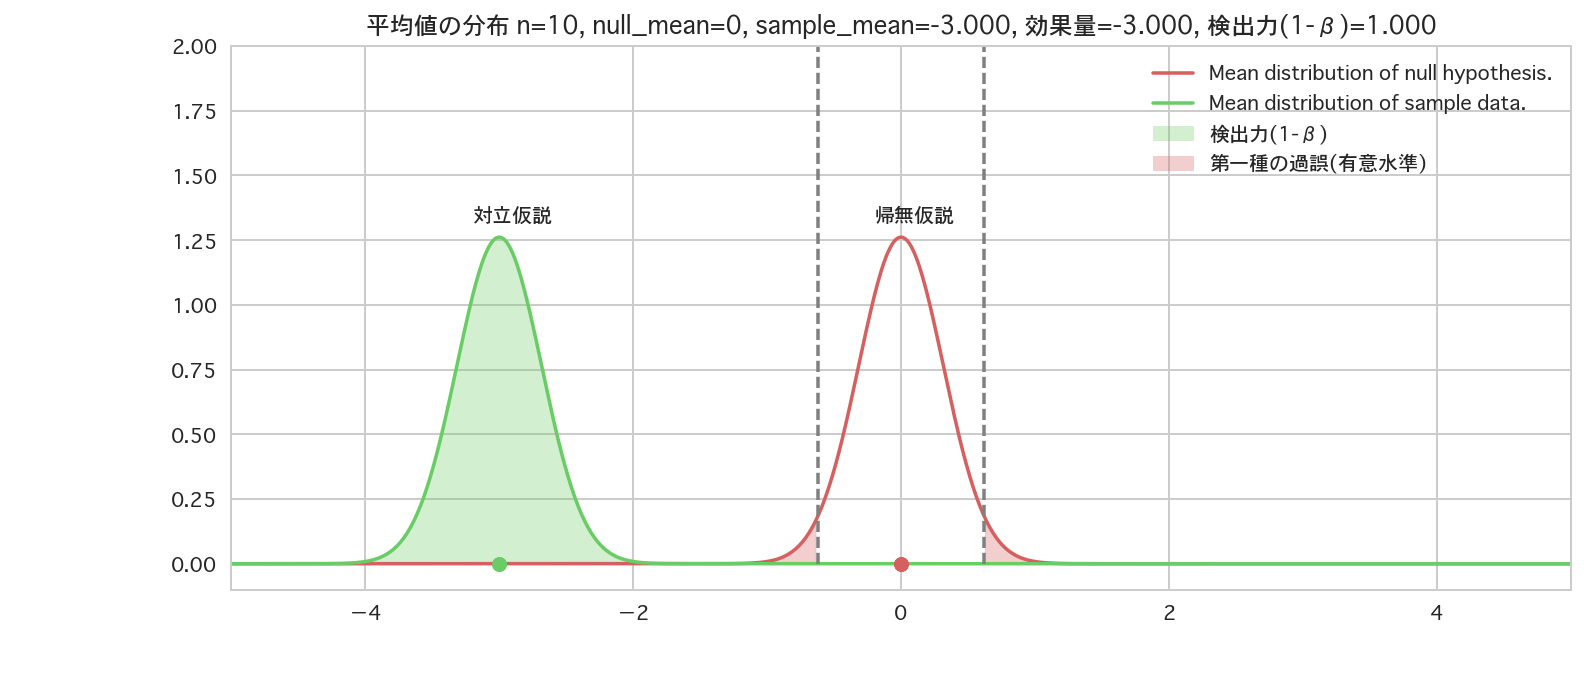

In [18]:
m_list = np.linspace(-3,3,51)
power_list = []
xx = None
def animate(nframe):
    global num_frame, fig, xx
    plt.clf()
    # サンプル数は10
    power = show_graph(null_hypo_mean=0, sample_mean=m_list[nframe], n=10, sd=1, 
               alpha=0.05, x_min=-5, x_max=5, y_min=-0.1, y_max=2, fig=fig)
    power_list.append(power)

num_frame = len(m_list)
fig = plt.figure(figsize=(12,5))
anim = ani.FuncAnimation(fig, animate, frames=int(num_frame))
anim.save('anim_test_effect_size.gif', writer='imagemagick', fps=5, dpi=128)

In [19]:
ipyd.Image(url='anim_test_effect_size.gif?i={}'.format(np.random.rand()))

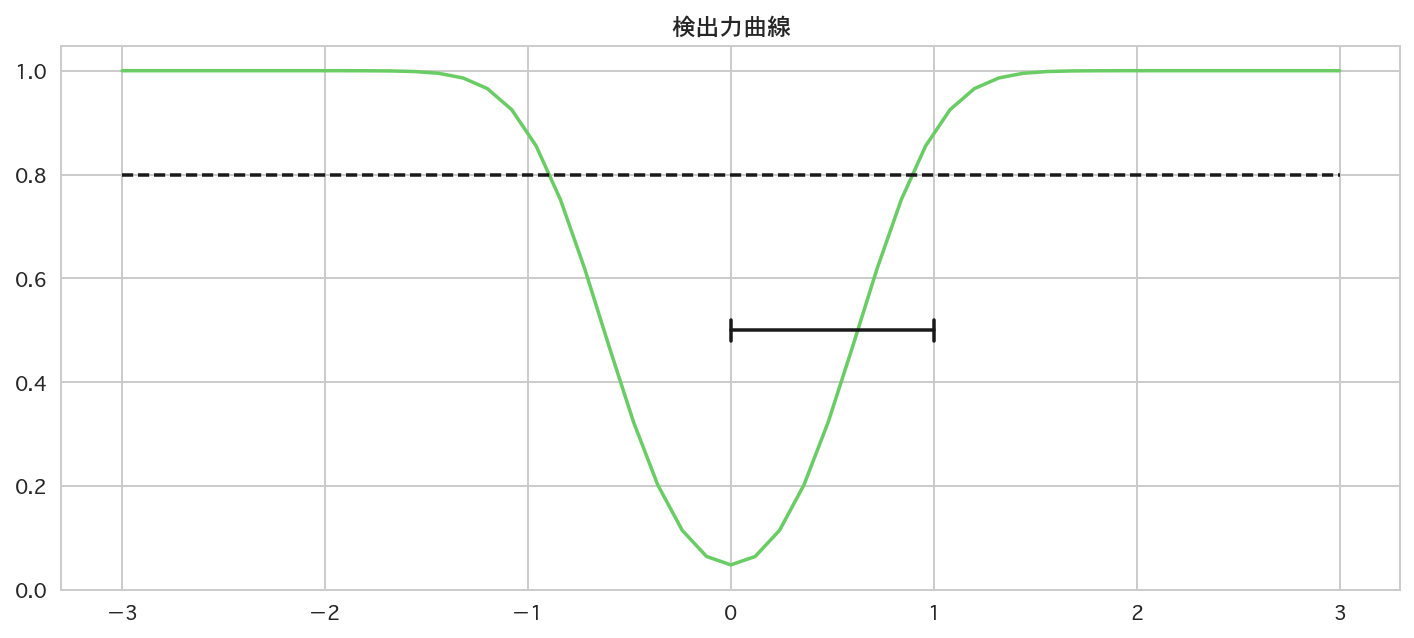

In [20]:
sd=1
null_hypo_mean = 0
fig = plt.figure(figsize=(12,5))
plt.plot(m_list, power_list[1:-1], "g")
plt.plot([np.min(m_list),np.max(m_list)],[0.8,0.8], "k--")

# 標準偏差バーの描画
plt.plot([null_hypo_mean, null_hypo_mean+sd],[0.5, 0.5], "k")
plt.plot([null_hypo_mean+sd, null_hypo_mean+sd],[0.48, 0.52], "k", label="std")
plt.plot([null_hypo_mean, null_hypo_mean],[0.48, 0.52], "k")
    
plt.title("検出力曲線")

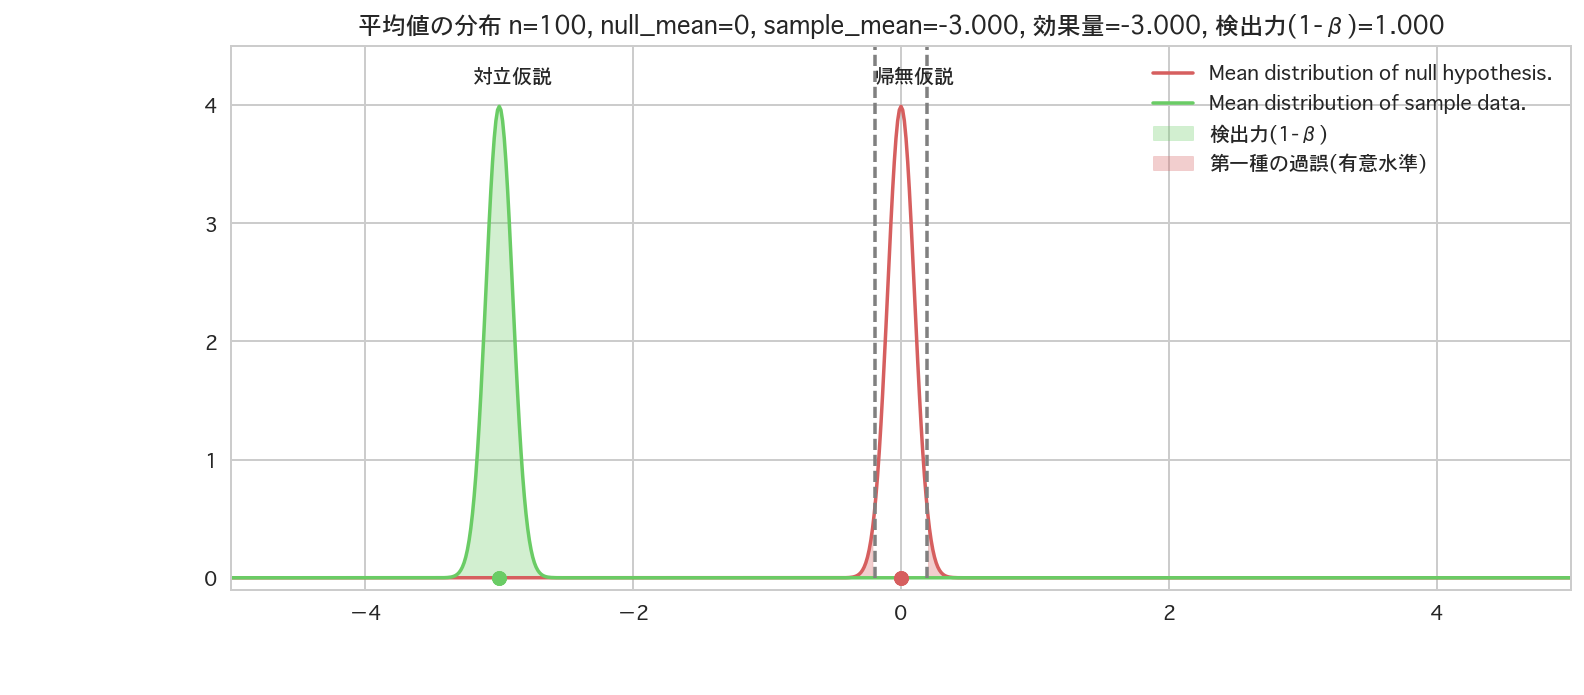

In [21]:
m_list = np.linspace(-3,3,51)
power_list = []
def animate(nframe):
    global num_frame, fig
    plt.clf()
    # サンプル数を100に
    power = show_graph(null_hypo_mean=0, sample_mean=m_list[nframe], n=100, sd=1, 
               alpha=0.05, x_min=-5, x_max=5, y_min=-0.1, y_max=4.5, fig=fig)
    power_list.append(power)
    
num_frame = len(m_list)
fig = plt.figure(figsize=(12,5))
anim = ani.FuncAnimation(fig, animate, frames=int(num_frame))
anim.save('anim_test_effect_size2.gif', writer='imagemagick', fps=5, dpi=128)

In [22]:
ipyd.Image(url='anim_test_effect_size2.gif?i={}'.format(np.random.rand()))

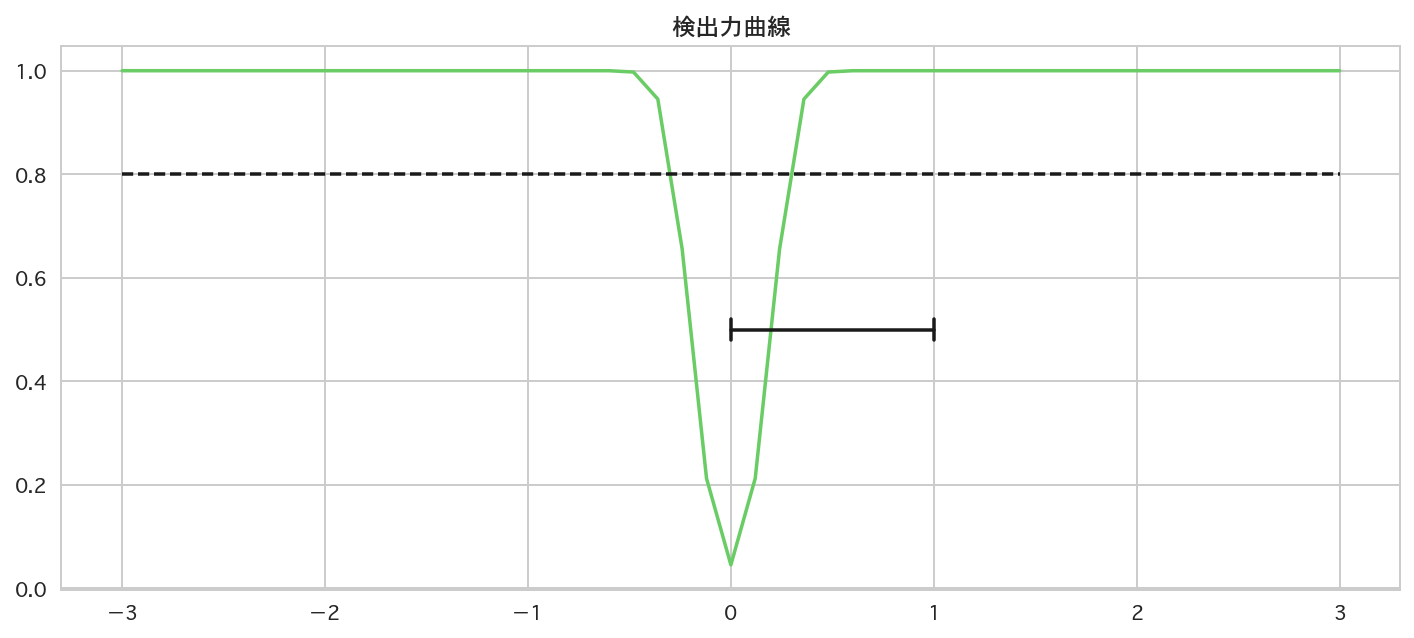

In [23]:
sd=1
null_hypo_mean = 0
fig = plt.figure(figsize=(12,5))
plt.plot(m_list, power_list[1:-1], "g")
plt.plot([np.min(m_list),np.max(m_list)],[0.8,0.8], "k--")

# 標準偏差バーの描画
plt.plot([null_hypo_mean, null_hypo_mean+sd],[0.5, 0.5], "k")
plt.plot([null_hypo_mean+sd, null_hypo_mean+sd],[0.48, 0.52], "k", label="std")
plt.plot([null_hypo_mean, null_hypo_mean],[0.48, 0.52], "k")
    
plt.title("検出力曲線")

In [53]:
show_graph(m1=100, effect_size=1, n1=10, n2=10, sd=1, alpha=0.05, x_min=96, x_max=105, y_min=-0.1, y_max=1.4)

TypeError: show_graph() got an unexpected keyword argument 'm1'

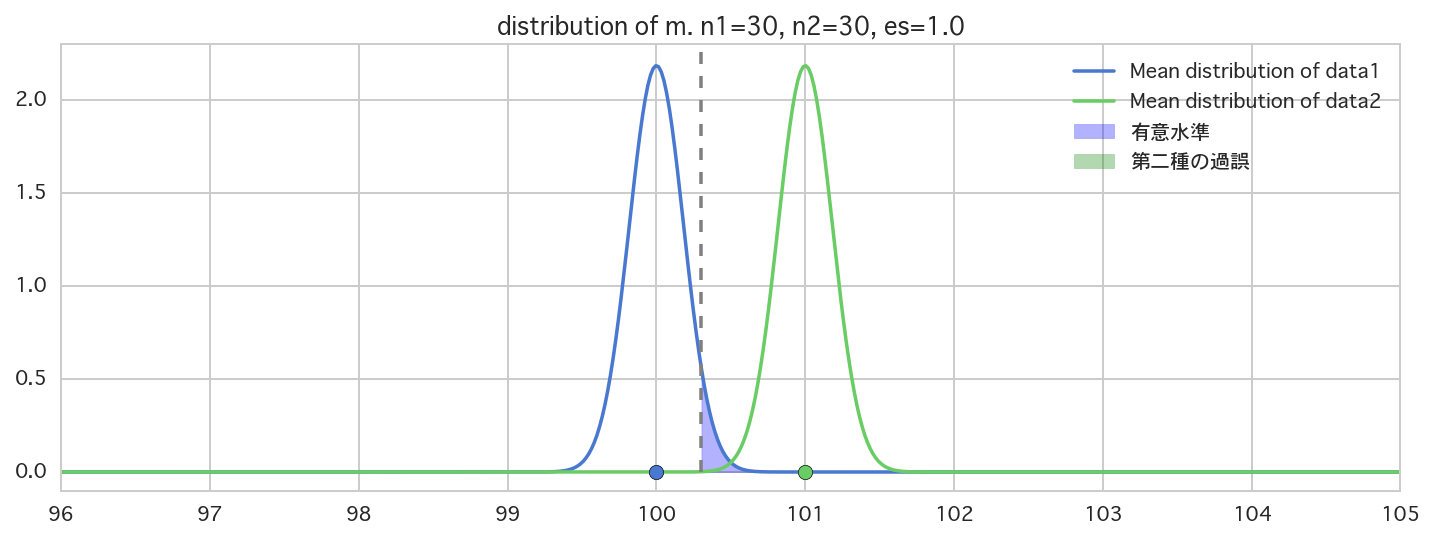

In [23]:
show_graph(m1=100, m2=101, n1=30, n2=30, sd=1, alpha=0.05, x_min=96, x_max=105, y_min=-0.1, y_max=2.3)

(-0.1, 1.4)

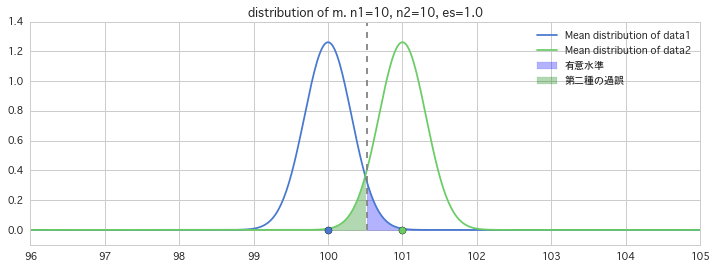

In [18]:
n1, n2 = 10, 10

# 平均値
m1, m2 = 100, 101

se1 = sd/np.sqrt(n1)
se2 = sd/np.sqrt(n2)
border = st.norm.isf(alpha, loc=m1, scale=se1)
border_idx = np.argmin(np.abs(xx-border))

pdf1 = st.norm.pdf(xx, loc=m1, scale=se1)
pdf2 = st.norm.pdf(xx, loc=m2, scale=se2)

# 青いエリアは有意水準、緑のエリアは第二種の過誤
plt.figure(figsize=(12,4))
plt.scatter([m1, m1], [0, 0], s=50, c="b", zorder=100)
plt.scatter([m2, m2], [0, 0], s=50, c="g", zorder=100)
plt.plot(xx, pdf1, label="Mean distribution of data1")
plt.plot(xx, pdf2, label="Mean distribution of data2")
plt.fill_between(xx[border_idx:], pdf1[border_idx:],alpha=0.3, color="blue", label="有意水準")
plt.fill_between(xx[:border_idx], pdf2[:border_idx],alpha=0.3, color="green", label="第二種の過誤")
plt.plot([border, border], [0, 1.4], "--", color="gray")
plt.title("distribution of m. n1={}, n2={}, es={}".format(n1, n2, effect_size))
plt.legend(loc="best")
plt.xlim(x_min, x_max)
plt.ylim(-0.1, 1.4)

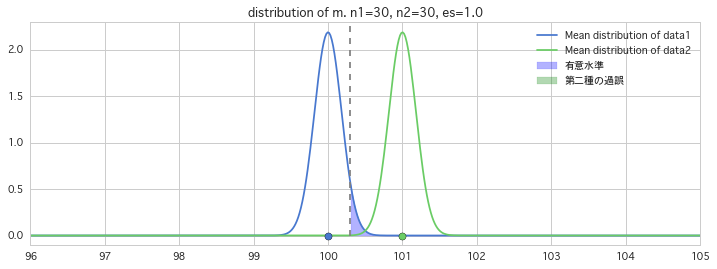

In [19]:
n1, n2 = 30, 30

# 平均値
m1, m2 = 100, 101

se1 = sd/np.sqrt(n1)
se2 = sd/np.sqrt(n2)
border = st.norm.isf(alpha, loc=m1, scale=se1)
border_idx = np.argmin(np.abs(xx-border))

pdf1 = st.norm.pdf(xx, loc=m1, scale=se1)
pdf2 = st.norm.pdf(xx, loc=m2, scale=se2)

plt.figure(figsize=(12,4))
plt.scatter([m1, m1], [0, 0], s=50, c="b", zorder=100)
plt.scatter([m2, m2], [0, 0], s=50, c="g", zorder=100)
plt.plot(xx, pdf1, label="Mean distribution of data1")
plt.plot(xx, pdf2, label="Mean distribution of data2")
plt.fill_between(xx[border_idx:], pdf1[border_idx:],alpha=0.3, color="blue", label="有意水準")
plt.fill_between(xx[:border_idx], pdf2[:border_idx],alpha=0.3, color="green", label="第二種の過誤")
plt.plot([border, border], [0, 2.3], "--", color="gray")
plt.legend(loc="best")
plt.xlim(x_min, x_max)
plt.ylim(-0.1, 2.3)
plt.title("distribution of m. n1={}, n2={}, es={}".format(n1, n2, effect_size))

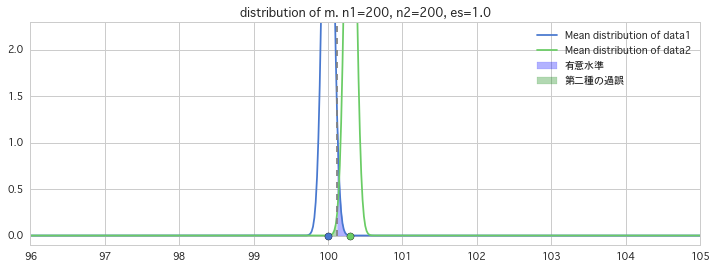

In [24]:
n1, n2 = 200, 200

# 平均値
m1, m2 = 100, 100.3

se1 = sd/np.sqrt(n1)
se2 = sd/np.sqrt(n2)
border = st.norm.isf(alpha, loc=m1, scale=se1)
border_idx = np.argmin(np.abs(xx-border))

pdf1 = st.norm.pdf(xx, loc=m1, scale=se1)
pdf2 = st.norm.pdf(xx, loc=m2, scale=se2)

plt.figure(figsize=(12,4))
plt.scatter([m1, m1], [0, 0], s=50, c="b", zorder=100)
plt.scatter([m2, m2], [0, 0], s=50, c="g", zorder=100)
plt.plot(xx, pdf1, label="Mean distribution of data1")
plt.plot(xx, pdf2, label="Mean distribution of data2")
plt.fill_between(xx[border_idx:], pdf1[border_idx:],alpha=0.3, color="blue", label="有意水準")
plt.fill_between(xx[:border_idx], pdf2[:border_idx],alpha=0.3, color="green", label="第二種の過誤")
plt.plot([border, border], [0, 2.3], "--", color="gray")
plt.legend(loc="best")
plt.xlim(x_min, x_max)
plt.ylim(-0.1, 2.3)
plt.title("distribution of m. n1={}, n2={}, es={}".format(n1, n2, effect_size))

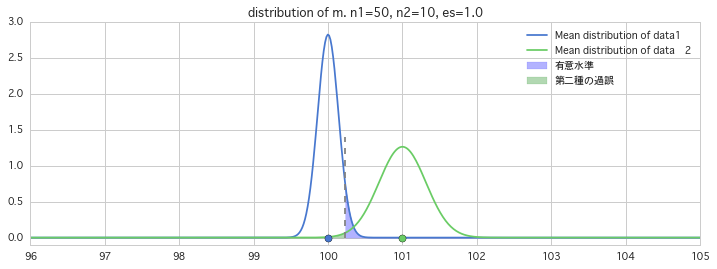

In [6]:
n1, n2 = 50, 10

se1 = sd/np.sqrt(n1)
se2 = sd/np.sqrt(n2)

pdf1 = st.norm.pdf(xx, loc=m1, scale=se1)
pdf2 = st.norm.pdf(xx, loc=m2, scale=se2)
border = st.norm.isf(alpha, loc=m1, scale=se1)
border_idx = np.argmin(np.abs(xx-border))

plt.figure(figsize=(12,4))
plt.scatter([m1, m1], [0, 0], s=50, c="b", zorder=100)
plt.scatter([m2, m2], [0, 0], s=50, c="g", zorder=100)
plt.plot(xx, pdf1, label="Mean distribution of data1")
plt.plot(xx, pdf2, label="Mean distribution of data　2")
plt.fill_between(xx[border_idx:], pdf1[border_idx:],alpha=0.3, color="blue", label="有意水準")
plt.fill_between(xx[:border_idx], pdf2[:border_idx],alpha=0.3, color="green", label="第二種の過誤")
plt.plot([border, border], [0, 1.4], "--", color="gray")
plt.legend(loc="best")
plt.xlim(x_min, x_max)
plt.ylim(-0.1, 3)
plt.title("distribution of m. n1={}, n2={}, es={}".format(n1, n2, effect_size))

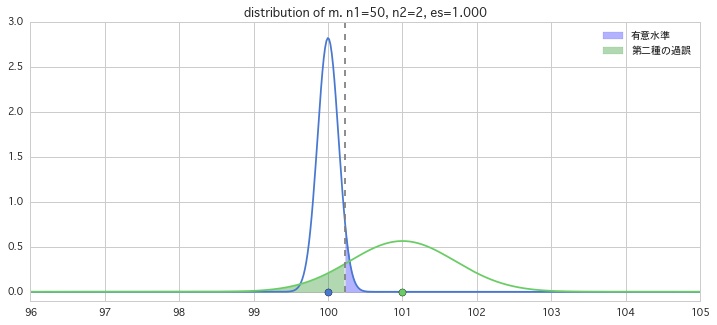

In [7]:
n1 = 50
n2_list = [2, 5, 10, 20, 40, 50]


def animate(nframe):
    global num_frame
    plt.clf()
    n2 = n2_list[nframe]

    se1 = sd/np.sqrt(n1)
    se2 = sd/np.sqrt(n2)
    effect_size = (m2-m1)/sd

    pdf1 = st.norm.pdf(xx, loc=m1, scale=se1)
    pdf2 = st.norm.pdf(xx, loc=m2, scale=se2)
    border = st.norm.isf(alpha, loc=m1, scale=se1)
    border_idx = np.argmin(np.abs(xx-border))

    plt.scatter([m1, m1], [0, 0], s=50, c="b", zorder=100)
    plt.scatter([m2, m2], [0, 0], s=50, c="g", zorder=100)
    plt.plot(xx, pdf1)
    plt.plot(xx, pdf2)
    plt.fill_between(xx[border_idx:], pdf1[border_idx:],alpha=0.3, color="blue", label="有意水準")
    plt.fill_between(xx[:border_idx], pdf2[:border_idx],alpha=0.3, color="green", label="第二種の過誤")
    plt.plot([border, border], [0, 3.0], "--", color="gray")
    plt.title("distribution of m. n1={0}, n2={1}, es={2:0.3f}".format(n1, n2, effect_size))
    plt.legend(loc="best")
    plt.xlim(x_min, x_max)
    plt.ylim(-0.1, 3)
    #plt.show()
    
    
num_frame = len(n2_list)
fig = plt.figure(figsize=(12,5))
anim = ani.FuncAnimation(fig, animate, frames=int(num_frame))
anim.save('anim_test.gif', writer='imagemagick', fps=3, dpi=64)

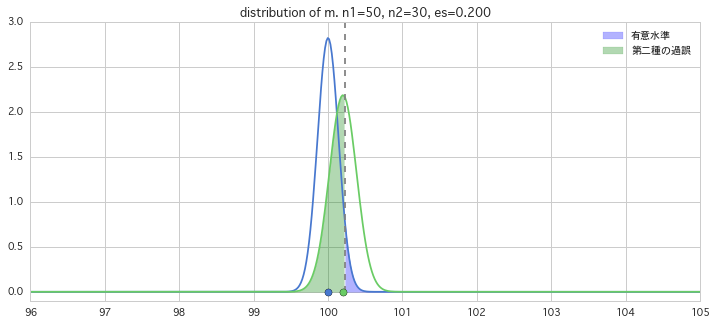

In [9]:
n1, n2 = 50, 30
m_list = list(np.arange(100.2,102,0.1))


def animate(nframe):
    global num_frame
    plt.clf()
    m2 = m_list[nframe]

    se1 = sd/np.sqrt(n1)
    se2 = sd/np.sqrt(n2)
    effect_size = (m2-m1)/sd

    pdf1 = st.norm.pdf(xx, loc=m1, scale=se1)
    pdf2 = st.norm.pdf(xx, loc=m2, scale=se2)
    border = st.norm.isf(alpha, loc=m1, scale=se1)
    border_idx = np.argmin(np.abs(xx-border))

    plt.scatter([m1, m1], [0, 0], s=50, c="b", zorder=100)
    plt.scatter([m2, m2], [0, 0], s=50, c="g", zorder=100)
    plt.plot(xx, pdf1)
    plt.plot(xx, pdf2)
    plt.fill_between(xx[border_idx:], pdf1[border_idx:],alpha=0.3, color="blue", label="有意水準")
    plt.fill_between(xx[:border_idx], pdf2[:border_idx],alpha=0.3, color="green", label="第二種の過誤")
    plt.plot([border, border], [0, 3.0], "--", color="gray")
    plt.title("distribution of m. n1={0}, n2={1}, es={2:0.3f}".format(n1, n2, effect_size))
    plt.legend(loc="best")
    plt.xlim(x_min, x_max)
    plt.ylim(-0.1, 3)
    #plt.show()
    
    
num_frame = len(m_list)
fig = plt.figure(figsize=(12,5))
anim = ani.FuncAnimation(fig, animate, frames=int(num_frame))
anim.save('anim_test_effect_size.gif', writer='imagemagick', fps=3, dpi=64)

In [10]:
ipyd.Image(url='anim_test_effect_size.gif?i={}'.format(np.random.rand()))

In [11]:

x1 = rd.normal(m1, sd/np.sqrt(n1), size=n1)
x2 = rd.normal(m2, sd/np.sqrt(n2), size=n2)


In [54]:
np.sqrt(10)

3.1622776601683795